<h1 style="text-align: center">
Deep Learning HW2 </br> 
Image Classification
</h1>

### Full Name: Amirhossein Safari
### Student ID: 14014121

## Import needed libraries


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
from tqdm import tqdm
from sklearn.metrics import classification_report

## Loading and Pre-Processing data

دانلود مجموعه داده FashionMNIST، با استفاده از مجموعه داده fashion mnist

In [ ]:
## Downloading FashionMNIST dataset, using fashion mnist dataset
train_set = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_set = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

100%|██████████| 26421880/26421880 [00:02<00:00, 12386572.08it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 210841.02it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3930885.63it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 21613890.88it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



 تقسیم مجموعه آموزشی به داده‌های قطار و اعتبارسنجی

In [ ]:
# splitting training set into train and validation data
train_size = 48000
val_size = 60000 - train_size
train_ds, val_ds = random_split(train_set, [train_size, val_size])

 بارگذاری مجموعه داده در حافظه با استفاده از Dataloader
 سایز دسته ای استفاده شده برابر با 64 و shuffle اجرا شده است

In [ ]:
# Loading the dataset into memory using Dataloader
# Used batch size equal to 64 and shuffle is implemented
batch_size = 64
train_dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_ds, batch_size=batch_size)
test_dataloader = DataLoader(test_set, batch_size=batch_size)
classes = train_set.classes

**Display some images from dataset**

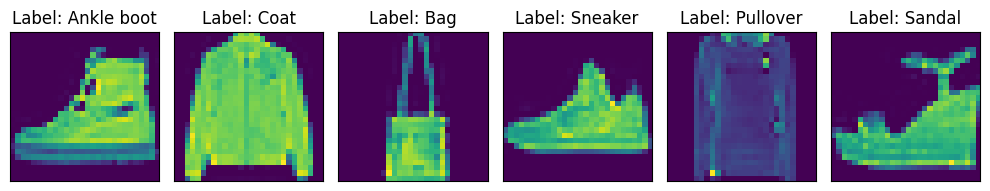

In [ ]:
# get some random training images
dataiter = iter(train_dataloader)
images, labels = next(dataiter)
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(10, 8), subplot_kw={'xticks': [], 'yticks': []})
for i,ax in zip(range(0,6),axes.flat):
    img,label=images[i],labels[i]
    ax.imshow(img.permute(1, 2, 0))
    ax.set_title(f"Label: {classes[label]}")

plt.tight_layout()
plt.show()

# Defining the Convolutional Neural Network

<img src='https://drive.google.com/uc?id=1Euy5_bGIiiYECSZUeEofgTImJWgQ0XLf'>

**<h2>Implement the model above in pytorch</h2>**

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# Definning architecture of above network
class Net(nn.Module):
    # لایه ها در تابع __init__ تعریف می شوند
    def __init__(self):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc1 = nn.Linear(2304, 600)
        self.fc2 = nn.Linear(600, 120)
        self.fc3 = nn.Linear(120, 10)
        
    #  forward pass در تابع forward تعریف شده است.
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out

In [ ]:
# Using GPU if it's available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

device(type='cuda')

In [ ]:
cnn_model = Net()
cnn_model.to(device)

Net(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)

# Defining Loss Function and optimizer
**Define appropriate Loss Function, Optimizer and Learning Rate**

نرخ یادگیری را 0.001 قرار دادیم.

تابع loss روی nn.CrossEntropyLoss() تنظیم شده است که معمولاً برای کارهای طبقه بندی چند کلاسه استفاده می شود.

بهینه ساز به صورت optim.Adam(net.parameters()، lr=learning_rate) تعریف می شود. از الگوریتم بهینه سازی adam برای به روز رسانی پارامترهای شبکه در طول آموزش استفاده می کند. آرگومان net.parameters() مشخص می کند که می خواهیم تمام پارامترهای شبکه عصبی را بهینه کنیم.

In [ ]:
import torch.optim as optim

learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=learning_rate)

**Define number of epochs and path to save the best model**

تعداد epoch ها 10 است

In [ ]:
epochs = 10
save_path="/content/cnn_model"

# Finally we will train our neural network

In [ ]:
# multiclass accuracy
def multi_acc(y_pred, y_test):
    _, y_pred_tags = torch.max(y_pred, dim = 1)    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    acc = torch.round(acc * 100)
    return acc

**Implementing the training algorithm and Saving the model with minimum Validation Loss**

In [ ]:
# training loop
def train_model(model, train_dataloader, val_dataloader, n_epochs, optimizer, criterion, device, save_path):
    train_losses = []
    val_losses = []
    valid_loss_min = np.Inf 

    for epoch in range(n_epochs):
        ####### Training Phase ########
        # در داخل حلقه، ابتدا مدل را روی حالت آموزشی (model.train()) 
        # قرار می دهد و روی داده بارگذار آموزشی تکرار می شود. داده ها و tensorهای هدف را به دستگاه مشخص شده منتقل می کند 
        # و برای محاسبه loss و به روز رسانی پارامترهای مدل، forward و backward را انجام می دهد.
        model.train()
        with tqdm(train_dataloader, unit="batch") as batches:
            epoch_loss = 0
            for data, target in batches:
                batches.set_description(f"Epoch {epoch + 1}")

                # move to GPU
                data = data.to(device)
                target = target.to(device)

                # zero the gradients
                optimizer.zero_grad()

                # forward pass
                output = model(data)
                loss = criterion(output, target)

                # backward pass and optimization
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()

                acc = multi_acc(output, target)
                batches.set_postfix(train_loss=loss.item(), train_accuracy=acc.item())  # show loss and accuracy per batch of data

        train_losses.append(epoch_loss)


        ####### Validation Phase ########
        # مدل را روی حالت ارزیابی قرار می‌دهد (model.eval()) و روی dataloader اعتبارسنجی تکرار می‌کند تا ضرر اعتبارسنجی را بدون محاسبه گرادیان محاسبه کند.
        model.eval()
        with torch.no_grad():
            valid_loss = 0.0
            # run the prediction on the validation dataloader
            for data, target in val_dataloader:
                # move to GPU
                data = data.to(device)
                target = target.to(device)

                # forward pass
                output = model(data)
                loss = criterion(output, target)

                valid_loss += loss.item()

        val_losses.append(valid_loss / len(val_dataloader))
        
        # print validation statistics 
        print('Epoch: {}  Validation Loss: {:.6f}'.format(epoch+1, valid_loss))

        ## If the valiation loss has decreased, then saving the model
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss 

    return model, train_losses, val_losses

**Train the model**

In [ ]:
# Train the model
# تابع train_model، عبور در مدل، بارگذارهای آموزشی و اعتبارسنجی، تعداد دوره‌ها، بهینه‌ساز، معیار از دست دادن، دستگاه و مسیر ذخیره را می‌نامیم. تابع مدل آموزش دیده (trained_model)، لیستی از trainnig loss در هر دوره (train_losses) و لیستی از loss اعتبارسنجی در هر دوره (val_losses) را برمی گرداند.
trained_model, train_losses, val_losses = train_model(cnn_model, train_dataloader, val_dataloader, epochs, optimizer, criterion, device, save_path)


Epoch 1: 100%|██████████| 750/750 [00:14<00:00, 52.44batch/s, train_accuracy=84, train_loss=0.47]


Epoch: 1  Validation Loss: 54.359665
Validation loss decreased (inf --> 54.359665).  Saving model ...


Epoch 2: 100%|██████████| 750/750 [00:14<00:00, 51.92batch/s, train_accuracy=91, train_loss=0.23]


Epoch: 2  Validation Loss: 46.551391
Validation loss decreased (54.359665 --> 46.551391).  Saving model ...


Epoch 3: 100%|██████████| 750/750 [00:13<00:00, 54.05batch/s, train_accuracy=97, train_loss=0.11]


Epoch: 3  Validation Loss: 46.824213


Epoch 4: 100%|██████████| 750/750 [00:13<00:00, 54.37batch/s, train_accuracy=92, train_loss=0.277]


Epoch: 4  Validation Loss: 50.827055


Epoch 5: 100%|██████████| 750/750 [00:16<00:00, 45.45batch/s, train_accuracy=95, train_loss=0.103]


Epoch: 5  Validation Loss: 46.569711


Epoch 6: 100%|██████████| 750/750 [00:13<00:00, 54.51batch/s, train_accuracy=92, train_loss=0.222]


Epoch: 6  Validation Loss: 48.574767


Epoch 7: 100%|██████████| 750/750 [00:14<00:00, 52.65batch/s, train_accuracy=92, train_loss=0.195]


Epoch: 7  Validation Loss: 53.719976


Epoch 8: 100%|██████████| 750/750 [00:13<00:00, 53.94batch/s, train_accuracy=95, train_loss=0.128]


Epoch: 8  Validation Loss: 53.161622


Epoch 9: 100%|██████████| 750/750 [00:13<00:00, 53.86batch/s, train_accuracy=86, train_loss=0.333]


Epoch: 9  Validation Loss: 55.106597


Epoch 10: 100%|██████████| 750/750 [00:13<00:00, 54.14batch/s, train_accuracy=98, train_loss=0.0561]


Epoch: 10  Validation Loss: 58.711758


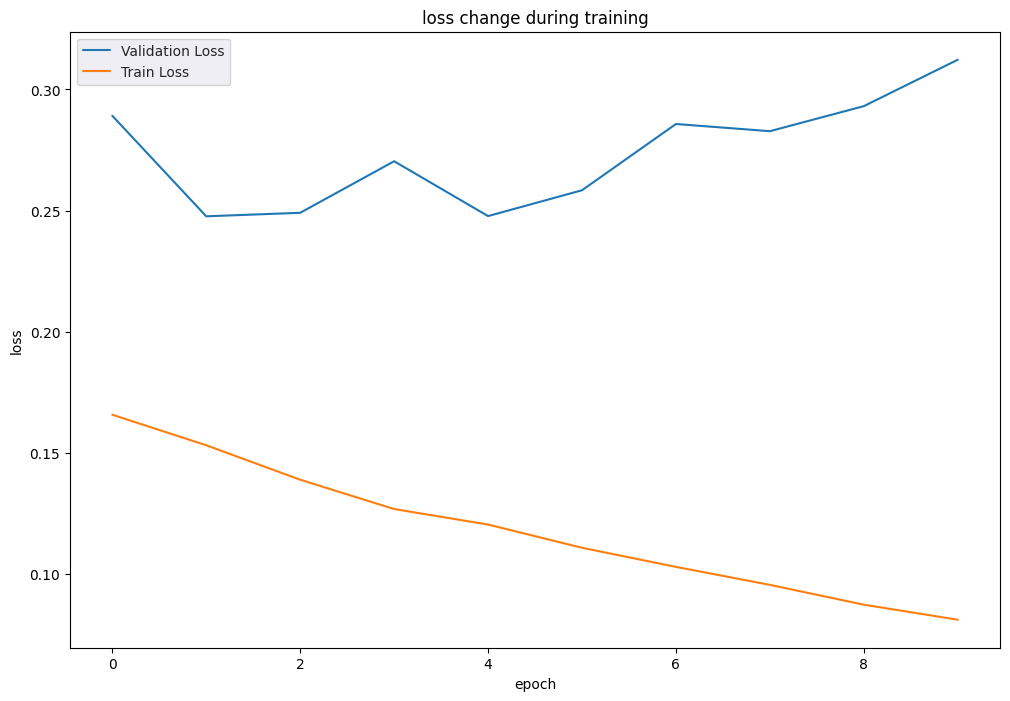

In [ ]:
# plot losses
plt.subplots(figsize=(12, 8))
sns.set_style("dark")
sns.lineplot(data=val_losses,label="Validation Loss")
sns.lineplot(data=np.asarray(train_losses)/1000,label="Train Loss").set(title="loss change during training", xlabel="epoch", ylabel="loss")
plt.legend()
plt.show()

# Prediction on Test Data

In [ ]:
def predict(images, model):
    # Set the model to evaluation mode
    model.eval()

    # Move images to the appropriate device
    device = next(model.parameters()).device
    images = images.to(device)

    # Forward pass to get the predicted outputs
    outputs = model(images)

    # Get the predicted labels
    # ما از torch.max (خروجی‌ها، 1) برای دریافت برچسب‌های پیش‌بینی‌شده استفاده می‌کنیم. تابع torch.max () حداکثر مقدار و شاخص آن را در طول یک بعد معین برمی گرداند.
    #  در این حالت از dim=1 برای بدست آوردن حداکثر مقدار و شاخص آن در امتداد بعد دوم (که نشان دهنده احتمالات پیش بینی شده برای هر کلاس است) استفاده می کنیم. 
    # برچسب های پیش بینی شده شاخص های حداکثر مقادیر هستند.
    _, predicted = torch.max(outputs, 1)

    return predicted

**Accuracy Result on Test Data**

In [ ]:
correct = 0
total = 0
y_pred_list = []
y_true_list = []

# ما از یک متن با torch.no_grad() برای غیرفعال کردن محاسبه گرادیان در طول فرآیند ارزیابی استفاده می کنیم
with torch.no_grad():
    for data in test_dataloader:
        # Get the inputs and labels from the test dataloader
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Make predictions using the predict function
        predicted = predict(inputs, cnn_model)

        # Update the correct and total counts
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        for  x in predicted.cpu().numpy(): y_pred_list.append(x)
        for  x in labels.cpu().numpy(): y_true_list.append(x)

# Calculate the accuracy
accuracy = 100 * correct / total
print('Accuracy of the network on the 10000 test images: %f %%' % accuracy)

Accuracy of the network on the 10000 test images: 90.050000 %


**Classification report**

In [ ]:
print(classification_report(y_true_list, y_pred_list, target_names=classes))

              precision    recall  f1-score   support

 T-shirt/top       0.87      0.85      0.86      1000
     Trouser       0.99      0.99      0.99      1000
    Pullover       0.74      0.94      0.83      1000
       Dress       0.91      0.90      0.90      1000
        Coat       0.88      0.78      0.83      1000
      Sandal       0.97      0.97      0.97      1000
       Shirt       0.80      0.67      0.73      1000
     Sneaker       0.94      0.97      0.96      1000
         Bag       0.94      0.99      0.96      1000
  Ankle boot       0.98      0.95      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



**Displaying a random set of images from test data**

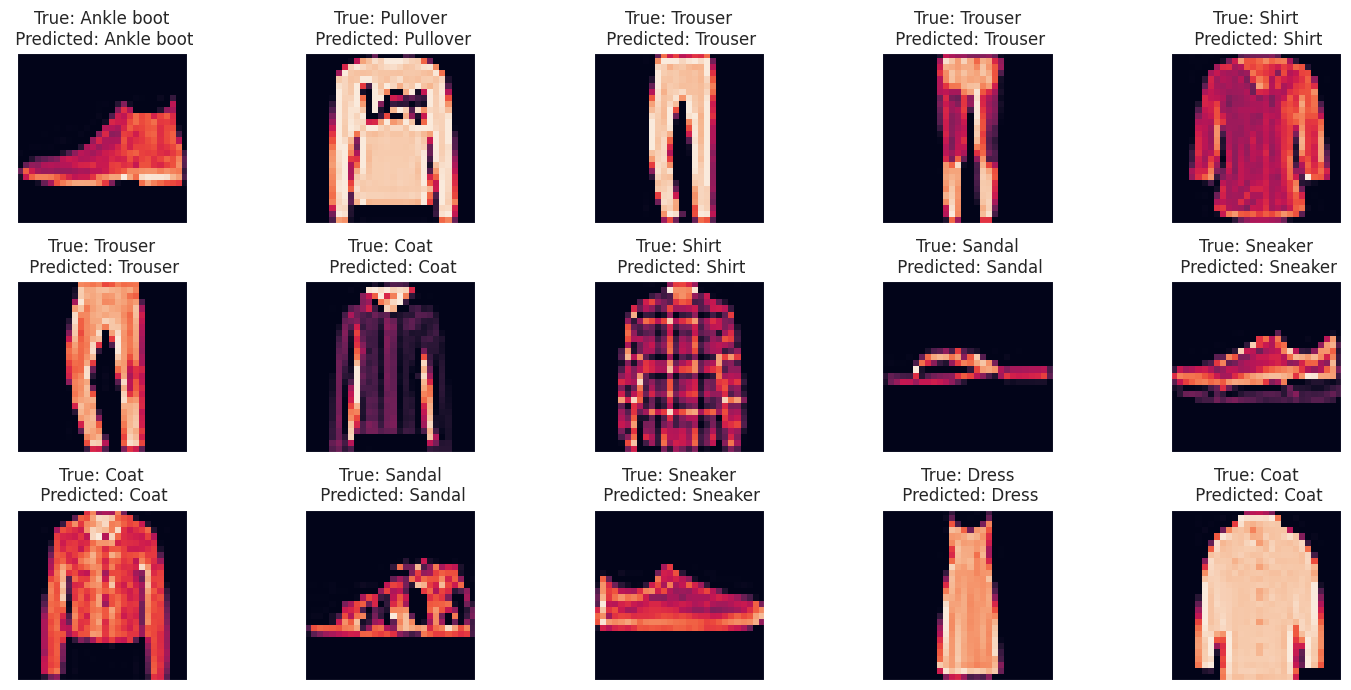

In [ ]:
dataiter = iter(test_dataloader)
images, labels = next(dataiter)
predicted=predict(images,cnn_model)

fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7), subplot_kw={'xticks': [], 'yticks': []})
for i,ax in zip(range(0,16),axes.flat):
    img,label=images[i],labels[i]
    pred=predicted[i]
    ax.imshow(img.permute(1, 2, 0))
    ax.set_title(f"True: {classes[label]}\n Predicted: {classes[pred]}")

plt.tight_layout()
plt.show()